In [2]:
# Load libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F


In [3]:
# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for computation")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Grayscale(),               # Convert to grayscale
    transforms.Resize((28, 28)),           # Resize to 28x28 (similar to MNIST)
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])


Using cpu for computation


In [4]:
# Path to the dataset folders
train_data_path = '/Users/hassanadnan/Desktop/PA2 2/CNN_lp_dataset/train'
val_data_path = '/Users/hassanadnan/Desktop/PA2 2/CNN_lp_dataset/val'

# Load training and validation datasets
train_dataset = ImageFolder(root=train_data_path, transform=transform)
val_dataset = ImageFolder(root=val_data_path, transform=transform)

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [5]:

# Define the CNN model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened output size from conv layers
        self.fc2 = nn.Linear(128, 36)          # 36 output classes for 0-9 and A-Z

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output from the conv layers
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Output layer with log_softmax for classification
        return F.log_softmax(x, dim=1)

# Example model instance
model = CNNNet().to(device)
print(model)




CNNNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)


In [6]:
# Initialize the model, loss function, and optimizer
# Initialize the model, move to the correct device
model = CNNNet().to(device)

# Define the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Define the training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move data and target to the correct device (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: Compute predicted output
        output = model(data)

        # Compute loss (Negative log-likelihood loss in this case)
        loss = criterion(output, target)

        # Backpropagation: Compute gradients
        loss.backward()

        # Update the weights using optimizer
        optimizer.step()

        # Print the training progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


In [8]:
def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0  # Initialize test loss
    correct = 0    # Initialize correct prediction count

    with torch.no_grad():  # Disable gradient calculation during testing
        for data, target in test_loader:

            # Move data and target to the correct device (GPU/CPU)
            data, target = data.to(device), target.to(device)

            # Forward pass: compute output
            output = model(data)

            # Sum up batch loss
            test_loss += criterion(output, target).item()  # Loss without backward pass

            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()  # Check how many predictions are correct

    # Average loss for the test set
    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [9]:
n_epochs = 5  # Number of epochs for training

for epoch in range(1, n_epochs + 1):
    # Train the model for one epoch
    train(model, device, train_loader, optimizer, epoch)

    # Evaluate the model on the validation set
    test(model, device, val_loader)  # Assuming val_loader is for validation data

    # Optionally, you can save the model at each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')


Train Epoch: 1 [0/1903 (0%)]	Loss: 3.611984

Test set: Average loss: 0.0069, Accuracy: 428/458 (93%)

Train Epoch: 2 [0/1903 (0%)]	Loss: 0.085005

Test set: Average loss: 0.0038, Accuracy: 443/458 (97%)

Train Epoch: 3 [0/1903 (0%)]	Loss: 0.114049

Test set: Average loss: 0.0021, Accuracy: 450/458 (98%)

Train Epoch: 4 [0/1903 (0%)]	Loss: 0.105902

Test set: Average loss: 0.0017, Accuracy: 448/458 (98%)

Train Epoch: 5 [0/1903 (0%)]	Loss: 0.067429

Test set: Average loss: 0.0020, Accuracy: 449/458 (98%)



In [10]:
# Set the device (use GPU if available)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for computation")

# Define transformations for the dataset

transform = transforms.Compose([
    transforms.Grayscale(),               # Convert to grayscale
    transforms.Resize((28, 28)),           # Resize to 28x28
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])


Using cpu for computation


In [11]:
# Write down batch generator to load data

# Path to the dataset folders
train_data_path = '/Users/hassanadnan/Desktop/PA2 2/CNN_lp_dataset/train'
val_data_path = '/Users/hassanadnan/Desktop/PA2 2/CNN_lp_dataset/val'

# Load the training and validation datasets
train_dataset = ImageFolder(root=train_data_path, transform=transform)
val_dataset = ImageFolder(root=val_data_path, transform=transform)

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [12]:
# Define the convolutional neural network model

class CNNNetSmall(nn.Module):
    def __init__(self):
        super(CNNNetSmall, self).__init__()
        # Convolutional layers with fewer filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers with fewer neurons
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Output size from conv layers is 32 * 7 * 7
        self.fc2 = nn.Linear(64, 36)          # 36 output classes (for 0-9 and A-Z)

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output from the conv layers
        x = x.view(-1, 32 * 7 * 7)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Output layer with log_softmax for classification
        return F.log_softmax(x, dim=1)

# Instantiate the model and move it to the device
model = CNNNetSmall().to(device)
print(model)


CNNNetSmall(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=36, bias=True)
)


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print(f"Trainable parameters: {count_parameters(model)}")


Trainable parameters: 107556


In [14]:
# Initialize the model, loss function, and optimizer

# Initialize the model and move to the correct device
model = CNNNetSmall().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam with learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Define the training function

def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to device
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


In [16]:
# Define the testing function

def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            # Move data and target to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Compute loss
            test_loss += criterion(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Collect predictions and targets for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Average loss for the test set
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.0f}%)\n')

    return all_preds, all_targets


In [17]:
# Training loop

n_epochs = 5  # Number of epochs
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)  # Train model for one epoch
    all_preds, all_targets = test(model, device, val_loader)  # Evaluate the model after each epoch


Train Epoch: 1 [0/1903 (0%)]	Loss: 3.595784

Test set: Average loss: 0.0204, Accuracy: 368/458 (80%)

Train Epoch: 2 [0/1903 (0%)]	Loss: 0.552175

Test set: Average loss: 0.0056, Accuracy: 432/458 (94%)

Train Epoch: 3 [0/1903 (0%)]	Loss: 0.138844

Test set: Average loss: 0.0037, Accuracy: 443/458 (97%)

Train Epoch: 4 [0/1903 (0%)]	Loss: 0.035222

Test set: Average loss: 0.0039, Accuracy: 444/458 (97%)

Train Epoch: 5 [0/1903 (0%)]	Loss: 0.225776

Test set: Average loss: 0.0019, Accuracy: 449/458 (98%)



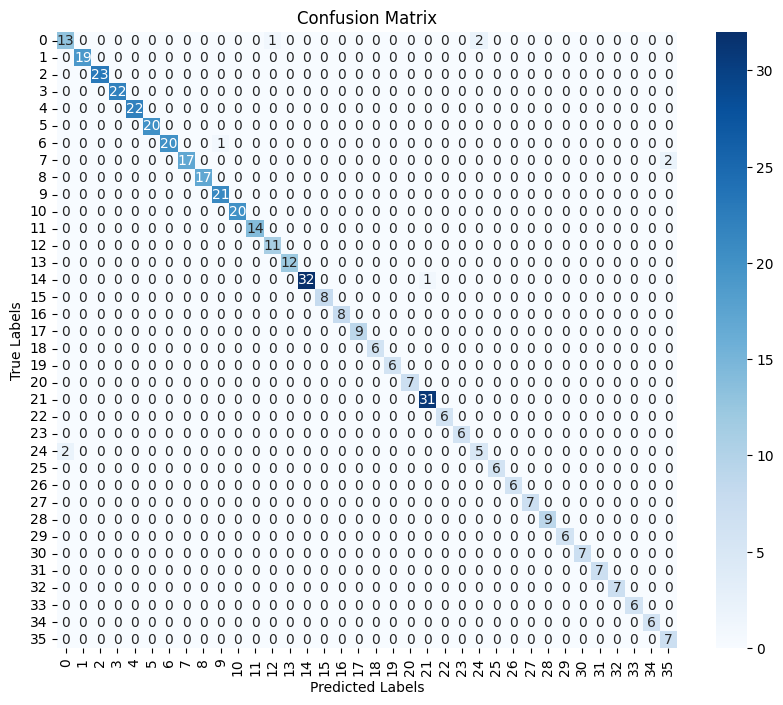

Precision: 98.14%
Recall: 98.03%
F1 Score: 98.04%


In [18]:
# show confusion matrix, calculate precision (P%), Recall (R%), and F1 Score (f1%)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(all_targets, all_preds, average='weighted') * 100
recall = recall_score(all_targets, all_preds, average='weighted') * 100
f1 = f1_score(all_targets, all_preds, average='weighted') * 100

print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')


In [19]:
# Assume 'model' is your trained CNN model
import torch

# Save the model's state dictionary
torch.save(model.state_dict(), 'cnn_model_part1.pth')
print("Model saved successfully!")


Model saved successfully!
